In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pdb import set_trace
import direct
from direct.misc import RBF_RFFs, KronMatrix, KhatriRaoMeshgrid, log_softmax
import tensorflow as tf

# Two-Variable Model
First generate a one-dimensional toy-dataset that that we will fit with a DIRECT generalized linear model with two discrete latent variables so that we can visualize our variational posterior distribution.
Because our hypothesis space is so small with this two variable model, we can also compute the exact posterior distribution and visualize that as well.
We will use a mean-field variational distribution and will place a uniform prior over the discrete states that each latent variable can take.

It is evident from the plots that the variational distribution placed the probability mass in the correct location but this mean-field distribution cannot capture all the features of the exact posterior.
Looking at the predictive posterior, it is evident that the predictive posterior mean is very accurate.

[ 00:23:02 ] direct.models INFO: Inititializing model
[ 00:23:02 ] direct.models INFO: Beginnning training iterations. n_epochs=1000
[ 00:23:02 ] direct.models INFO: using L-BFGS-B optimizer
Epoch: 0001, ELBO: -7566.2152, Time elapsed: 0.3334 seconds.
Epoch: 0005, ELBO: -19.893955, Time elapsed: 0.3566 seconds.
Epoch: 0010, ELBO: 86.31064, Time elapsed: 0.3726 seconds.
Epoch: 0015, ELBO: 89.500266, Time elapsed: 0.3906 seconds.
Epoch: 0020, ELBO: 89.600019, Time elapsed: 0.4096 seconds.
Epoch: 0025, ELBO: 89.603137, Time elapsed: 0.4276 seconds.
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -89.603225
  Number of iterations: 27
  Number of functions evaluations: 28
[ 00:23:03 ] tensorflow INFO: Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -89.603225
  Number of iterations: 27
  Number of functions evaluations: 28
Optimiza

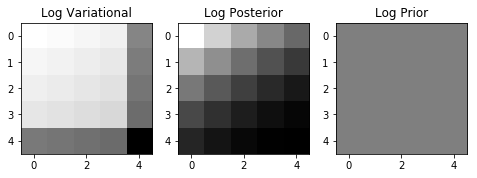

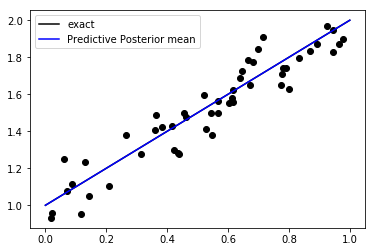

In [24]:
np.random.seed(0)

# create a fake dataset from a 1D linear model with a bias term and corrupt with
# independent Gaussian noise
n = 50
noise_variance = 0.01
x = np.random.rand(n,1);
Phi = np.hstack((x, np.ones(x.shape)))
xx = np.linspace(0,1,num=50).reshape((-1,1))
Phi_X = np.hstack((xx, np.ones(xx.shape)))
w_exact = 1.
y = w_exact*np.sum(Phi,axis=1,keepdims=True)
y += np.random.normal(size=(n,1), scale=np.sqrt(noise_variance)) # add some noise

# initialize the W grid of discrete values the latent variables can take, and the prior / variational distibution
wbar = [-1.,-0.5,0.,0.5,1.]
Wbar = np.array([wbar,]*Phi.shape[1])
mbar = Wbar.shape[1]
P = np.zeros((Phi.shape[1], mbar)) + 1./mbar # prior for weights

# train the direct model
with tf.Session() as sess:
    # reinitialize the model and compute the ELBO with initial variational distribution set to prior
    m = direct.BayesGLM(Phi=Phi, sig2_grid=np.atleast_1d(noise_variance), y=y, Wbar=Wbar, logP=np.log(P), logpsig=np.zeros(1))
    sess.run(tf.global_variables_initializer())
    trace = m.train(n_epochs=1000, sess=sess, display_step=5)
    Q = sess.run(tf.exp(m.logQ))
    qsig = sess.run(tf.exp(m.logqsig))
    y_mean = sess.run(m.predict_mean(Phi_X=Phi_X))

# compute the exact posterior for comparison with the learned variational distribution
W = KhatriRaoMeshgrid(Wbar).expand()
# compute the exact log-likelihood
logl_exact = np.zeros((W.shape[1],1))
for i,w in enumerate(W.T): # loop through each possible set of parameters
    logl_exact[i] = -np.sum(np.power(y-Phi.dot(w.reshape((-1,1))), 2))/(2.*noise_variance) - n*np.log(noise_variance)/2
# compute the exact parameter posterior
prior_expanded = KronMatrix(np.expand_dims(P, axis=2)).expand()
log_posterior = log_softmax(logl_exact + prior_expanded, axis=0).reshape((mbar,)*m.b, order='F')
# get the prior and the variational dist
log_prior = prior_expanded.reshape((mbar,)*m.b, order='F')
log_variational = np.log(KronMatrix(np.expand_dims(Q,axis=2)).expand()).reshape((mbar,)*m.b, order='F')
# get the min and max values of everything so that I can plot it all on the same scale
vmin = np.min(np.hstack((log_posterior, log_prior, log_variational)))
vmax = np.max(np.hstack((log_posterior, log_prior, log_variational)))

# plot the posterior distribution of the latent variables
fig, ax_arr = plt.subplots(ncols=3, figsize=(8,4))
ax_arr[0].imshow(log_variational, interpolation='None', cmap='gray_r')#, vmin=vmin, vmax=vmax)
ax_arr[0].set_title('Log Variational')
ax_arr[1].imshow(log_posterior, interpolation='None', cmap='gray_r')#, vmin=vmin, vmax=vmax)
ax_arr[1].set_title('Log Posterior')
ax_arr[2].imshow(log_prior, interpolation='None', cmap='gray_r', vmin=log_prior.min()-0.1, vmax=log_prior.max()+0.1)
ax_arr[2].set_title('Log Prior');

# plot the predictive posterior mean
fig, ax = plt.subplots()
ax.plot(x,y,'ko')
ax.plot(xx, w_exact*(xx+1.), 'k', label='exact')
ax.plot(xx, y_mean, 'b', label='Predictive Posterior mean')
ax.legend(loc=0);